In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#thêm dữ liệu
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/flight_data.csv', encoding='utf-8')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6489062 entries, 0 to 6489061
Data columns (total 92 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   MONTH                                      int64  
 1   DEP_DEL15                                  int64  
 2   DISTANCE_GROUP                             int64  
 3   SEGMENT_NUMBER                             int64  
 4   CONCURRENT_FLIGHTS                         int64  
 5   AIRPORT_FLIGHTS_MONTH                      int64  
 6   AIRLINE_AIRPORT_FLIGHTS_MONTH              int64  
 7   GROUND_SERV_PER_PASS                       float64
 8   PLANE_AGE                                  int64  
 9   LONGITUDE                                  float64
 10  PREVIOUS_AIRPORT                           int64  
 11  PRCP                                       float64
 12  SNOW                                       float64
 13  SNWD                                      

In [5]:
def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type == 'category':
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            # Convert object types to category
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

df = reduce_mem_usage(df)

Memory usage of dataframe is 1305.76 MB
Memory usage after optimization is: 1107.73 MB
Decreased by 15.2%


## Chia tập dữ liệu

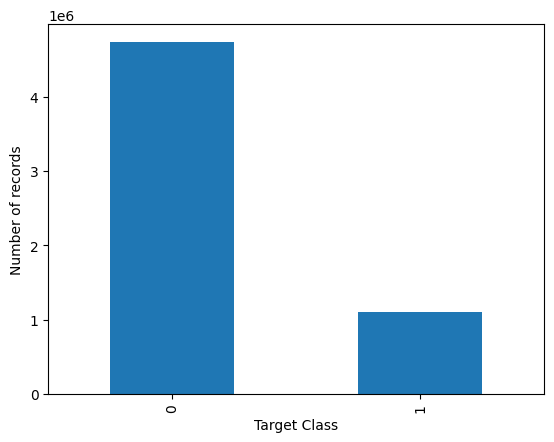

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('DEP_DEL15', axis=1), df['DEP_DEL15'], test_size=0.1, random_state=42)
count = y_train.value_counts()
count.plot.bar()
plt.ylabel('Number of records')
plt.xlabel('Target Class')
plt.show()

rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_under = scaler.fit_transform(X_train_under)
X_test = scaler.transform(X_test)

## Thuộc tính quan trọng

                                      Feature  Importance
33                     DEP_TIME_BLK_2300-2359    0.104149
16                     DEP_TIME_BLK_0600-0659    0.080942
32                     DEP_TIME_BLK_2200-2259    0.035585
17                     DEP_TIME_BLK_0700-0759    0.034679
39          CARRIER_NAME_Delta Air Lines Inc.    0.026152
18                     DEP_TIME_BLK_0800-0859    0.025302
70                        DEPARTING_STATE_ MN    0.024859
2                              SEGMENT_NUMBER    0.021048
47        CARRIER_NAME_Southwest Airlines Co.    0.019915
42        CARRIER_NAME_Hawaiian Airlines Inc.    0.019232
43               CARRIER_NAME_JetBlue Airways    0.018258
31                     DEP_TIME_BLK_2100-2159    0.017110
86                        DEPARTING_STATE_ TX    0.016801
87                        DEPARTING_STATE_ UT    0.015602
74                        DEPARTING_STATE_ NJ    0.015387
19                     DEP_TIME_BLK_0900-0959    0.015361
29            

<Figure size 1600x1000 with 0 Axes>

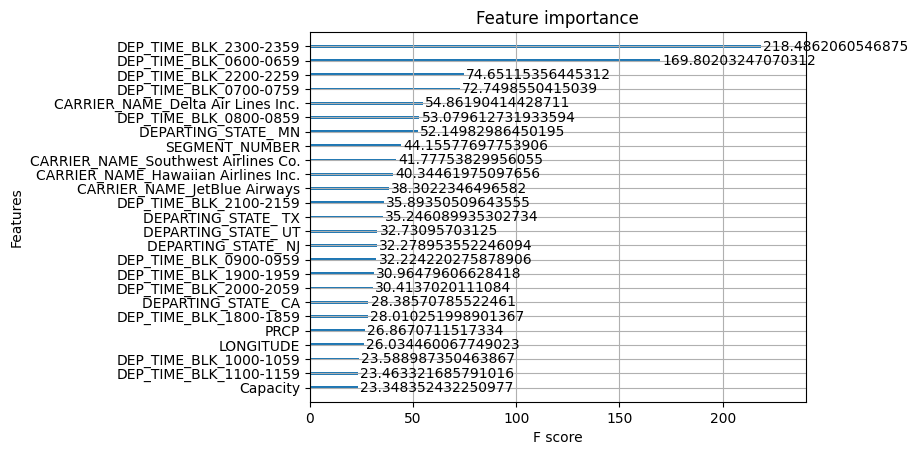

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
print(importance_df)
# Vẽ biểu đồ
plt.figure(figsize=(16, 10))
plot_importance(xgb, max_num_features=25, importance_type='gain')
plt.show()